In [8]:
import pandas as pd
from astropy.io import fits
import astropy
import astropy.constants as c
import numpy as np
import pandas as pd
from sncosmo import read_snana_fits
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import LeastSquares

In [10]:
head = '/media/ELAsTICC/data/training_sample/ELASTICC_TRAIN_SNIa-91bg/ELASTICC_TRAIN_NONIaMODEL0-0001_HEAD.FITS.gz'
phot = '/media/ELAsTICC/data/training_sample/ELASTICC_TRAIN_SNIa-91bg/ELASTICC_TRAIN_NONIaMODEL0-0001_PHOT.FITS.gz'
lcs = read_snana_fits(head, phot)

## Find the winnner

In [11]:
sizes = []

for i in lcs:
    sizes.append(len(i['PHOTFLAG'][i['PHOTFLAG']!=0]))
    
rows = np.arange(0, len(lcs))
order_sizes, order_rows = zip(*sorted(zip(sizes, rows), reverse=True))

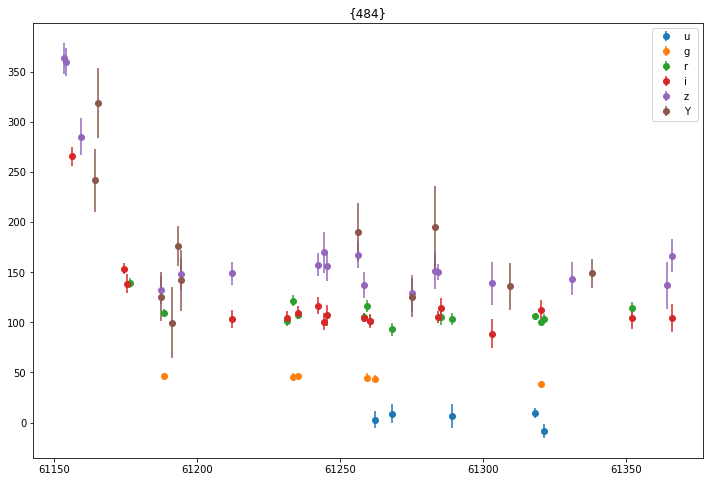

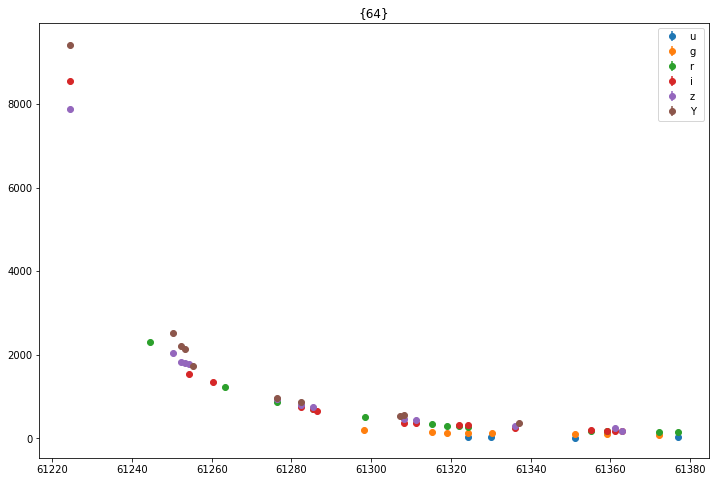

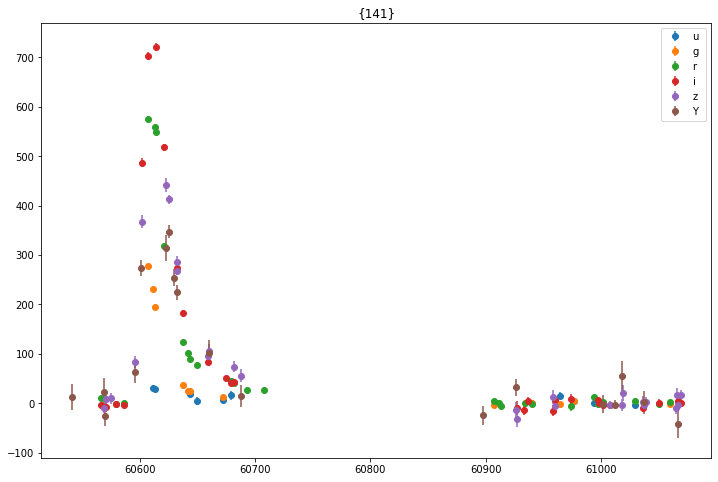

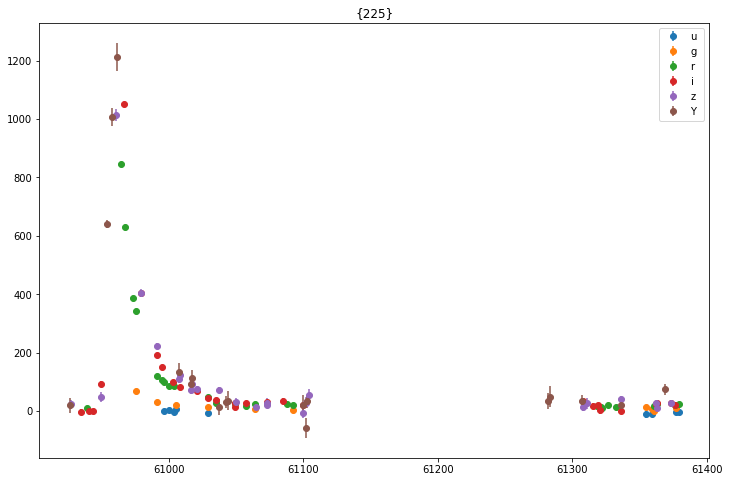

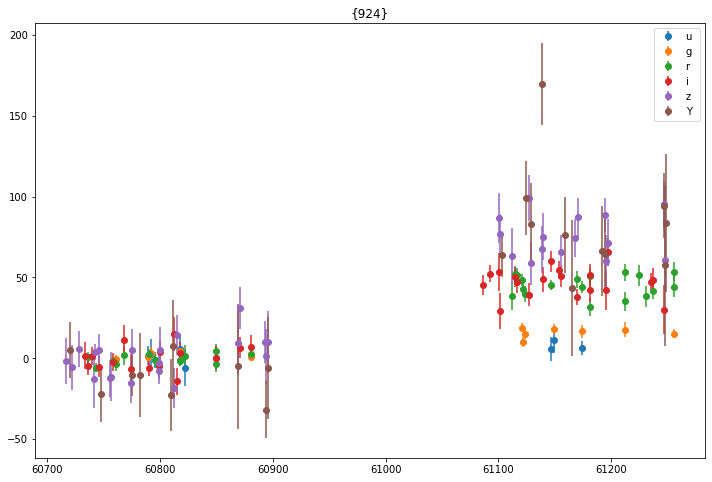

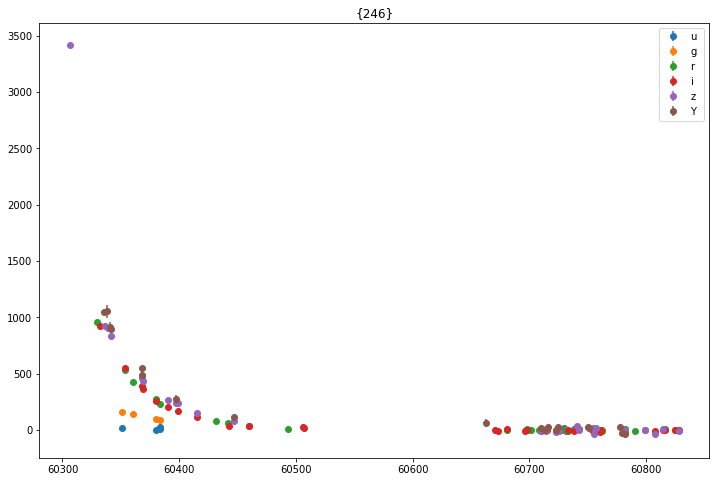

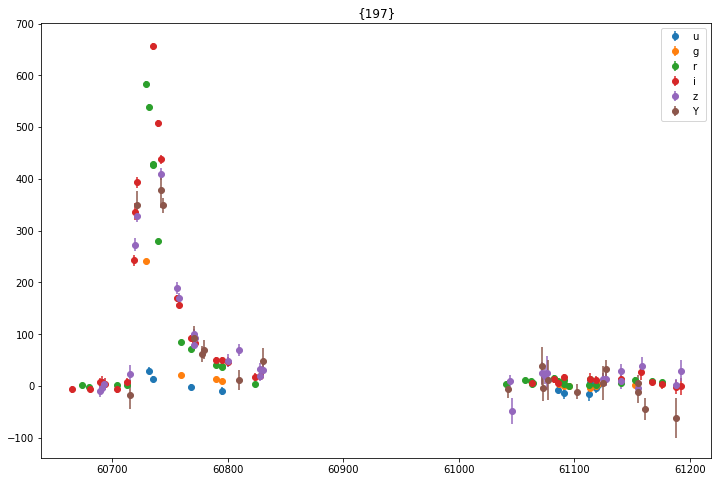

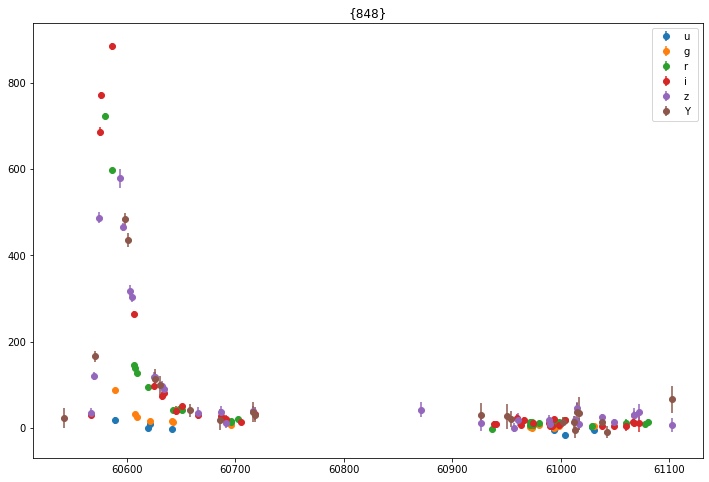

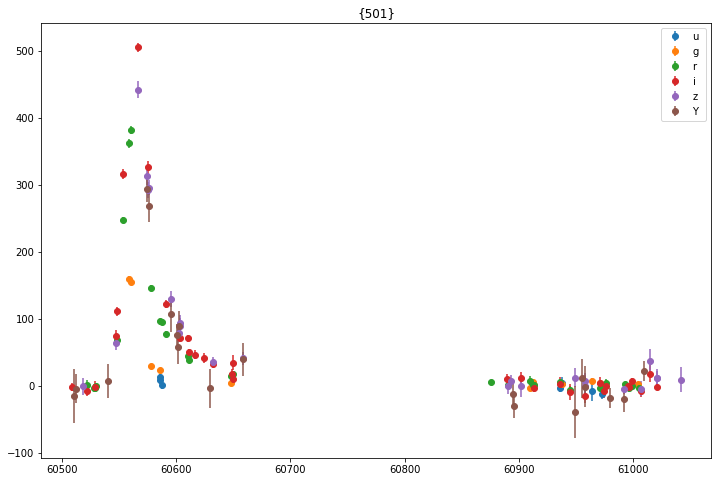

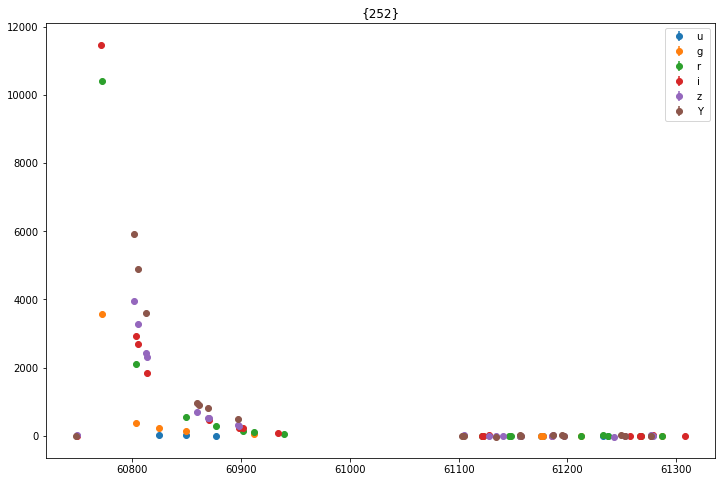

In [12]:
batch = 0
batch_size = 10

for obj in order_rows[batch*batch_size : batch*batch_size + batch_size]:
    
    plt.figure(figsize = (12, 8))
    
    for band in ['u ','g ','r ','i ','z ','Y ']:

        
        single = lcs[obj]#[lcs[obj]['PHOTFLAG']!=0]
        
        single_band = single[single['BAND'] == band]
        flux = single_band['FLUXCAL']
        fluxerr = single_band['FLUXCALERR']
        mjd = single_band['MJD']

        plt.errorbar(mjd, flux, yerr=fluxerr, fmt='o', label = band)
        plt.title({obj})
    
        plt.legend()

In [13]:
winner = 141

In [14]:
def protected_exponent(x1):
    """Exponential function : cannot exceed e**10

    Examples
    --------
    >>> np.round_(protected_exponent(42), 5)
    22026.46579
    >>> np.round_(protected_exponent(1), 5)
    2.71828
    """
    maxi = 100
    with np.errstate(over="ignore"):
        return np.where(x1 < maxi, np.exp(x1), np.exp(maxi))
    
    
def bazinB(time, a, b, t0, tfall, trise):
    """
    Parametric light curve function proposed by Bazin et al., 2009.
    
    Parameters
    ----------
    time : np.array
        exploratory variable (time of observation)
    a: float
        Normalization parameter
    b: float
        Shift parameter
    t0: float
        Time of maximum
    tfall: float
        Characteristic decline time
    trise: float
        Characteristic raise time
        
    Returns
    -------
    array_like
        response variable (flux)
    """

    X = protected_exponent(-(time - t0) / tfall) / (1 + protected_exponent((time - t0) / trise))
    
    return a * X + b

def bump(x, p1, p2, p3, a, b, t0):

    return a * (sig(p1 * (x-t0) + p2 - protected_exponent(p3 * (x-t0)))) + b



def sig(x):
    """Sigmoid function using the protected exponential function

    Examples
    --------
    >>> sig(0)
    0.5
    """

    return 1 / (1 + protected_exponent(-x))

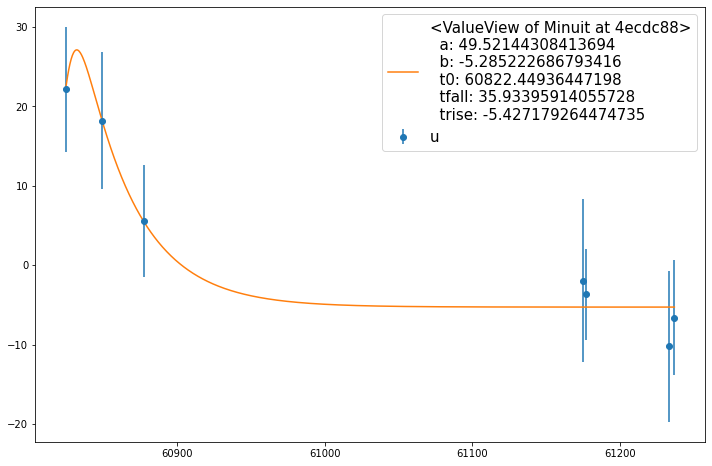

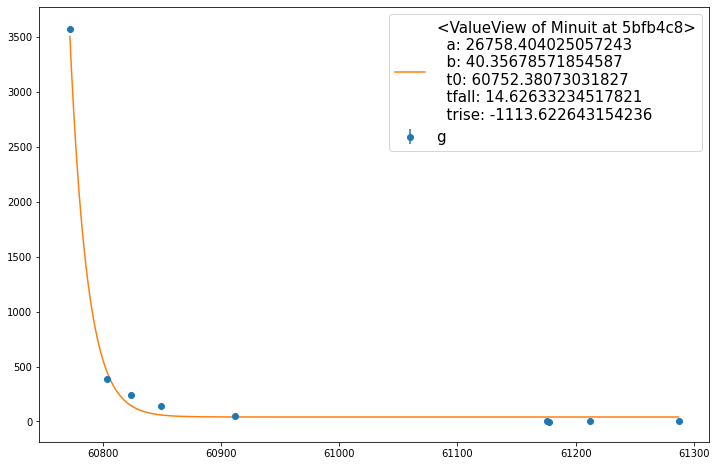

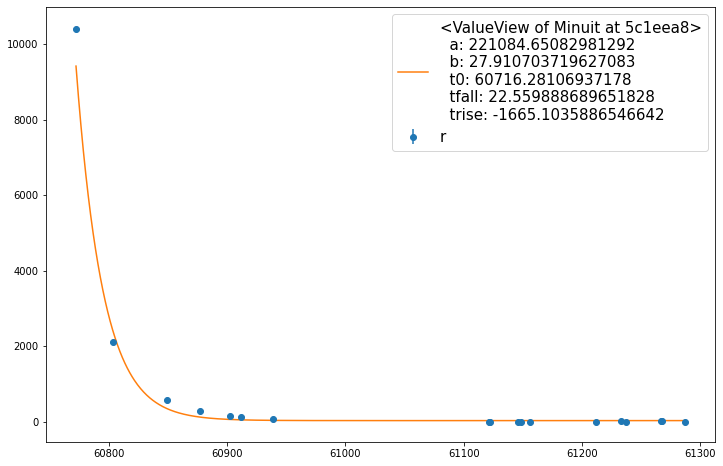

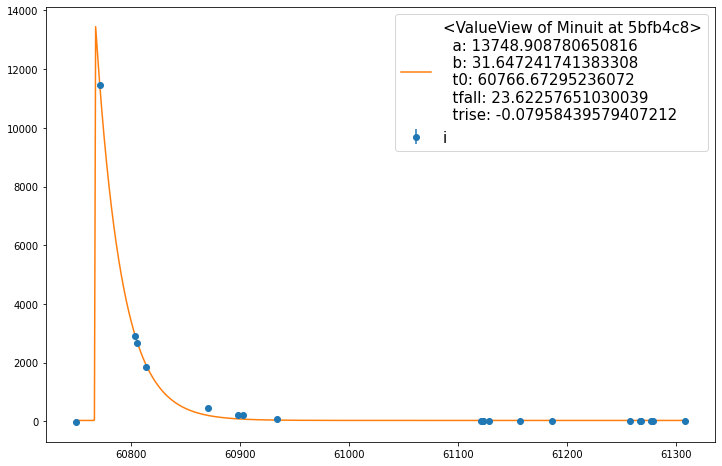

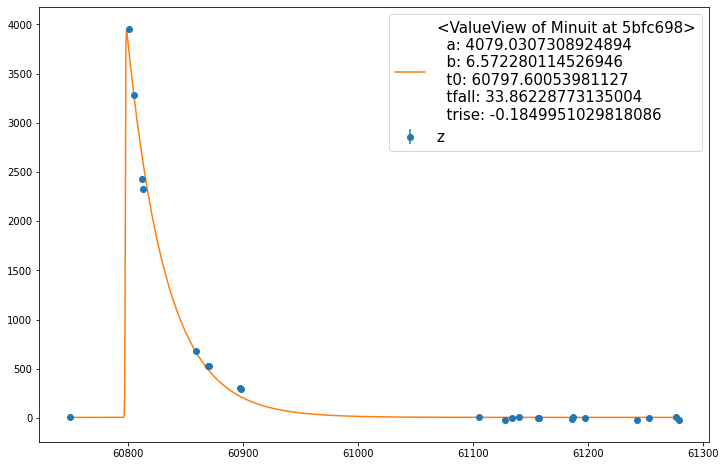

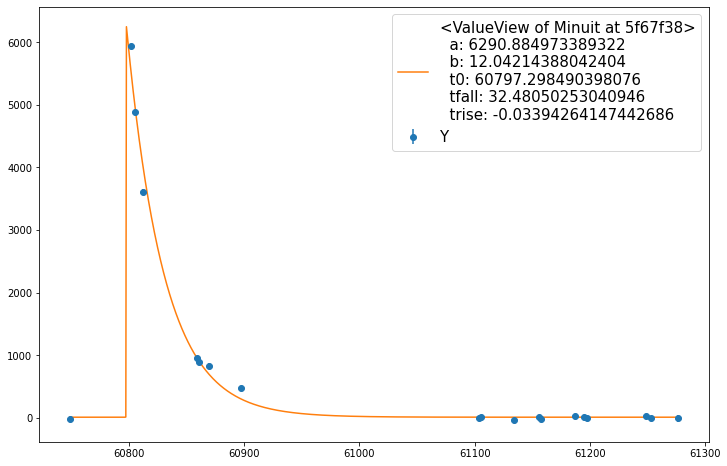

In [15]:
usebump = False

for band in ['u ','g ','r ','i ','z ','Y ']:

    plt.figure(figsize = (12, 8))
    obj = lcs[winner]

    single_band = single[single['BAND'] == band]
    flux = single_band['FLUXCAL']
    fluxerr = single_band['FLUXCALERR']
    mjd = single_band['MJD']
    
    x = np.linspace(mjd.min(), mjd.max(), 1000)

    if usebump:
        parameters_dict = {'p1':0.225, 'p2':-2.5, 'p3':0.038, "a": flux.max(), "b":0, "t0": mjd[np.argmax(flux)]}
        least_squares = LeastSquares(mjd, flux, fluxerr, bump)
        
    else:
        parameters_dict = {"a": flux.max(), "b":0, "t0": mjd[np.argmax(flux)], "tfall": 30, "trise":-5}
        least_squares = LeastSquares(mjd, flux, fluxerr, bazinB)
        
    fit = Minuit(least_squares, **parameters_dict)

    fit.migrad()

    plt.errorbar(mjd, flux, yerr=fluxerr, fmt='o', label = band)
    
    if usebump:
        plt.plot(x, bump(x, **fit.values), label=fit.values)
        
    else:
        plt.plot(x, bazinB(x, **fit.values), label=fit.values)
    
    plt.legend(fontsize = 15)

# Create the bolometric flux function (that depends on time and frequency) :

The fit will therefore be in 3D

In [16]:
# Bolometric flux computed using bazin
def Fbaz(t, a, t0, tfall, trise):
    return a * np.exp(-(t - t0) / tfall) / (1 + np.exp((t - t0) / trise))

def sig(x):
    return 1/(1+np.exp(-x))

def Fbump(t, t0, a, p1, p2, p3):
    return a*sig(p1 * (t-t0) + p2 - np.exp(p3 * (t-t0)))

# Temperature computed using sigmoid
def Tsig(t, Tmin, Tmax, ksig, t0, tT):
    return Tmin + (Tmax - Tmin)/(1+protected_exponent((t-(t0+tT))/ksig))

def plank(nu, T):
    return (2*c.h.value/c.c.value**2)*nu**3/np.expm1(c.h.value*nu/(c.k_B.value*T))

# Flux of lightcurves at any time at any frequency
def Fnu(x, a, t0, tT, tfall, trise, Tmin, Tmax, ksig):
    t, nu = x.T
    T = Tsig(t, Tmin, Tmax, ksig, t0, tT)
    Fbol = Fbaz(t, a, t0, tfall, trise)
    amplitude = 1e15
    
    return np.pi/c.sigma_sb.value * Fbol * plank(nu, T)/T**4 * amplitude

# Flux of lightcurves at any time at any frequency
def Fnu_bump(x, a, t0, tT, p1, p2, p3, Tmin, Tmax, ksig):
    t, nu = x.T
    T = Tsig(t, Tmin, Tmax, ksig, t0, tT)
    Fbol = Fbump(t, t0, a, p1, p2, p3)
    amplitude = 1e15
    
    return np.pi/c.sigma_sb.value * Fbol * plank(nu, T)/T**4 * amplitude

def Am_to_Hz(wl):
    return c.c.value/(wl*1e-10)
     


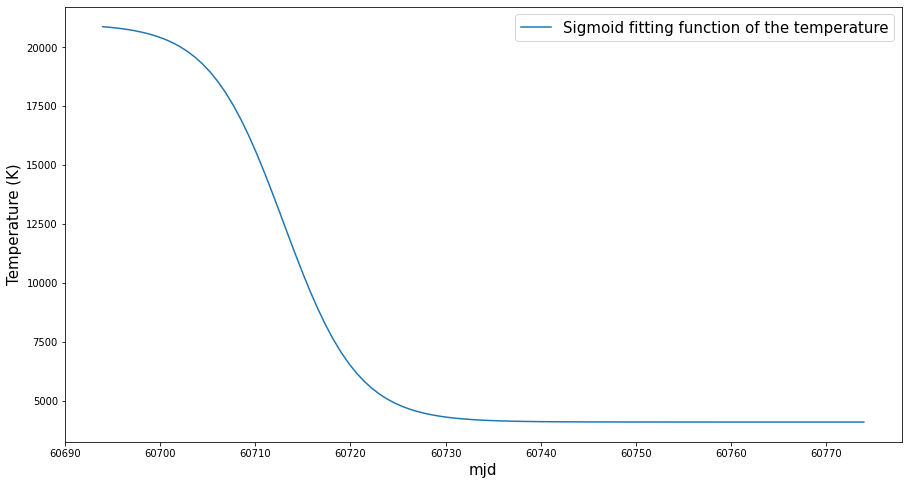

In [17]:
Tmin, Tmax, ksig, tT, t0 = 4.111e3, 21e3, 3.9, -11, 60.72397e3 

x_step = np.linspace(t0-30, t0+50, 100)
plt.figure(figsize = (15, 8))
plt.plot(x_step, Tsig(x_step, Tmin, Tmax, ksig, t0, tT), label='Sigmoid fitting function of the temperature')
plt.xlabel('mjd',fontsize = 15)
plt.ylabel('Temperature (K)',fontsize = 15)
plt.legend(fontsize = 15)

In [18]:
snia = lcs[winner]

nu_u = Am_to_Hz(3751.36)
nu_g = Am_to_Hz(4741.64)
nu_r = Am_to_Hz(6173.23)
nu_i = Am_to_Hz(7501.62)
nu_z = Am_to_Hz(8679.19)
nu_Y = Am_to_Hz(9711.53)
freq_dic = {'u ':nu_u, 'g ':nu_g, 'r ':nu_r, 'i ':nu_i, 'z ':nu_z, 'Y ':nu_Y}
snia['NU'] = np.vectorize(freq_dic.get)(list(snia['BAND']))


In [23]:
flux = snia['FLUXCAL']
fluxerr = snia['FLUXCALERR']
nu = snia['NU']
mjd = snia['MJD']
freq = snia['NU']


parameters_dict = {"a": flux.max(), "t0": mjd[np.argmax(flux)], "tT": 0,\
                   "tfall": 30, "trise":-5, "Tmin":4000, "Tmax":7000, "ksig":4}


#boundaries = {}

least_squares = LeastSquares(np.array([mjd, nu]).T, flux, fluxerr, Fnu)

fit = Minuit(least_squares,
             limit_Tmin=(1000, 50000),
             limit_Tmax=(2000, 100000),
             limit_a=(0, 100000),
             **parameters_dict)

fit.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1555                       │       Nfcn = 1117 (1117 total)       │
│ EDM = 9.86e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a     │    702    │    10     │            │            │    0    │ 100000  │       │
│ 1 │ t0    │60.60519e3 │ 0.00031e3 │            │            │         │         │       │
│ 2 │ tT    │    1.4    │    0.9    │            │            │         │         │       │
│ 3 │ tfall │   16.6    │    0.4    │            │            │         │         │       │
│ 4 │ trise │   -2.95   │   0.08    │            │            │         │         │       │
│ 5 │ Tmin  │  4.336e3  │  0.020e3  │            │            │  1000   │  50000  │       │
│ 6 │ Tmax  │  5.83e3   │  0.23e3   │            │            │  2000   │ 100000  │       │
│ 7 │ ksig  │    0.6    │    0.8    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

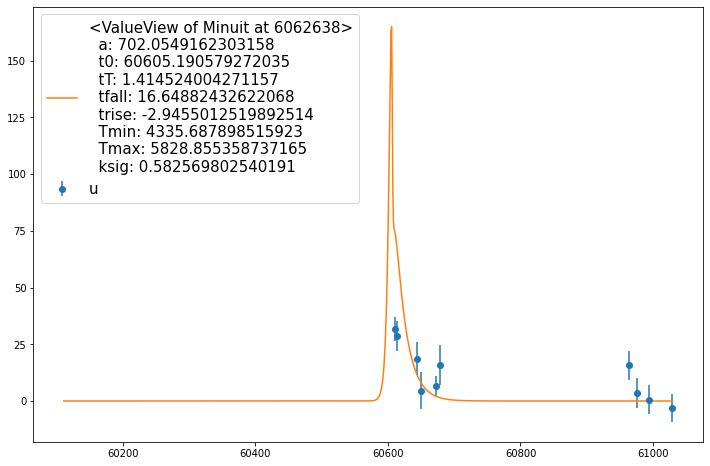

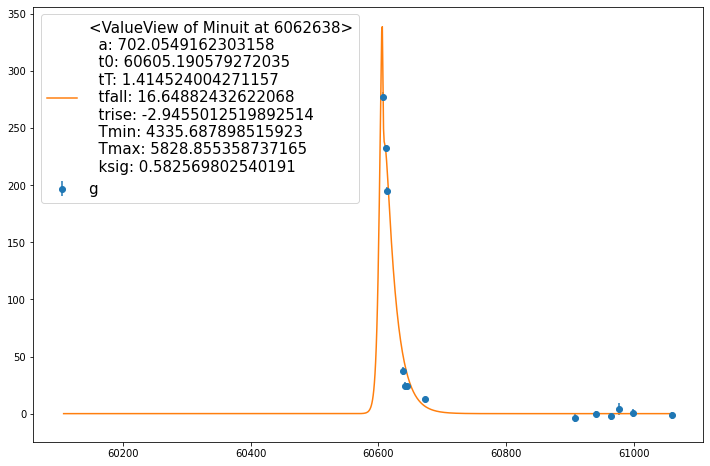

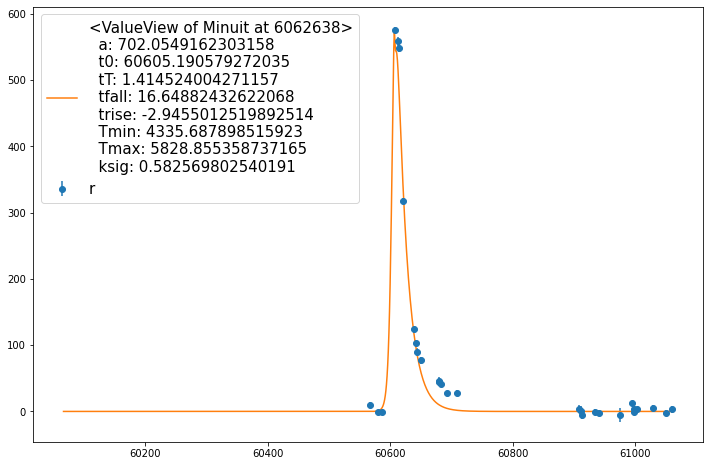

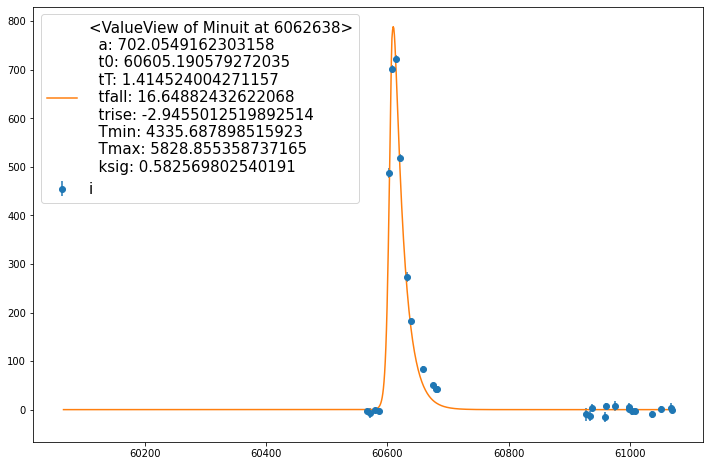

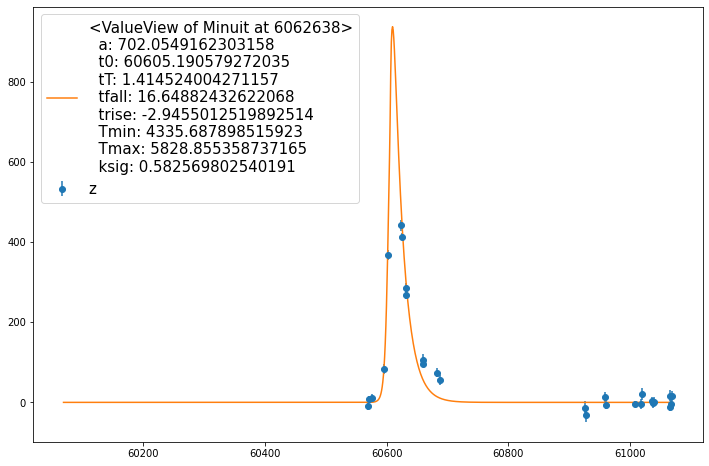

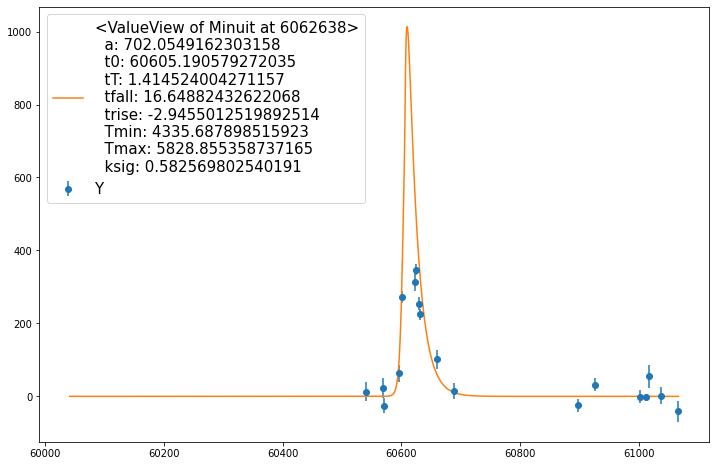

In [24]:
for band in ['u ','g ','r ','i ','z ','Y ']:

    plt.figure(figsize = (12, 8))
    obj = lcs[winner]

    single_band = obj[obj['BAND'] == band]
    flux = single_band['FLUXCAL']
    fluxerr = single_band['FLUXCALERR']
    mjd = single_band['MJD']

    xtime = np.linspace(mjd.min()-500, mjd.max(), 1000)
    x = np.array([xtime,[freq_dic.get(band)]*len(xtime)]).T

    plt.errorbar(mjd, flux, yerr=fluxerr, fmt='o', label = band)

    plt.plot(xtime, Fnu(x, **fit.values), label=fit.values)

    plt.legend(fontsize = 15)

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

Axes3D.scatter(xs, ys, zs=0, zdir='z', s=20, c=None, depthshade=True, *args, **kwargs)

    plt.figure(figsize = (12, 8))
    obj = lcs[winner]

    single_band = obj[obj['BAND'] == band]
    flux = single_band['FLUXCAL']
    fluxerr = single_band['FLUXCALERR']
    mjd = single_band['MJD']

    xtime = np.linspace(mjd.min()-500, mjd.max(), 1000)
    x = np.array([xtime,[freq_dic.get(band)]*len(xtime)]).T

    plt.errorbar(mjd, flux, yerr=fluxerr, fmt='o', label = band)

    plt.plot(xtime, Fnu(x, **fit.values), label=fit.values)

    plt.legend(fontsize = 15)

IndentationError: unexpected indent (<ipython-input-12-f5ed094bfdc0>, line 10)

## Using bump

In [44]:
%%time

flux = snia['FLUXCAL']
fluxerr = snia['FLUXCALERR']
nu = snia['NU']
mjd = snia['MJD']
freq = snia['NU']


parameters_dict_bump = {"a": flux.max(), "t0": mjd[np.argmax(flux)], "tT": 0,\
                   "p1": 0.225, "p2":-2.5, "p3":0.038,  "Tmin":4000, "Tmax":7000, "ksig":4}
print(parameters_dict_bump)
least_squares_bump = LeastSquares(np.array([mjd, nu]).T, flux, fluxerr, Fnu_bump)

fit_bump = Minuit(least_squares_bump, **parameters_dict_bump)

fit_bump.migrad()

{'a': 721.6033, 't0': 60614.2186, 'tT': 0, 'p1': 0.225, 'p2': -2.5, 'p3': 0.038, 'Tmin': 4000, 'Tmax': 7000, 'ksig': 4}
CPU times: user 196 ms, sys: 12 ms, total: 208 ms
Wall time: 186 ms


/media3/etienne/genetic_env/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 5060                       │       Nfcn = 1214 (1214 total)       │
│ EDM = 5.67e-06 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   406.0   │    2.9    │            │            │         │         │       │
│ 1 │ t0   │60.60486e3 │ 0.00006e3 │            │            │         │         │       │
│ 2 │ tT   │   16.77   │   0.06    │            │            │         │         │       │
│ 3 │ p1   │   1.25    │   0.08    │            │            │         │         │       │
│ 4 │ p2   │   4.40    │   0.15    │            │            │         │         │       │
│ 5 │ p3   │ 21.21e-3  │  0.33e-3  │            │            │         │         │       │
│ 6 │ Tmin │  1.943e3  │  0.008e3  │            │            │         │         │       │
│ 7 │ Tmax │  4.466e3  │  0.018e3  │            │            │         │         │       │
│ 8 │ ksig │   1.46    │   0.05    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

/media3/etienne/genetic_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in expm1
  app.launch_new_instance()
/media3/etienne/genetic_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in expm1
  app.launch_new_instance()
/media3/etienne/genetic_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in expm1
  app.launch_new_instance()
/media3/etienne/genetic_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in expm1
  app.launch_new_instance()
/media3/etienne/genetic_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in expm1
  app.launch_new_instance()
/media3/etienne/genetic_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in expm1
  app.launch_new_instance()


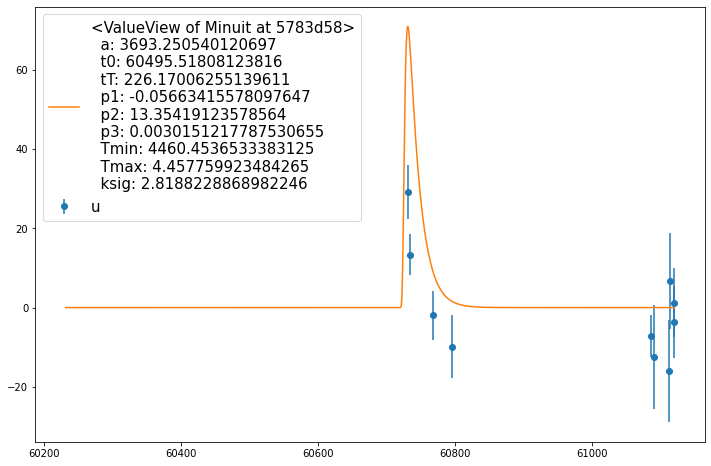

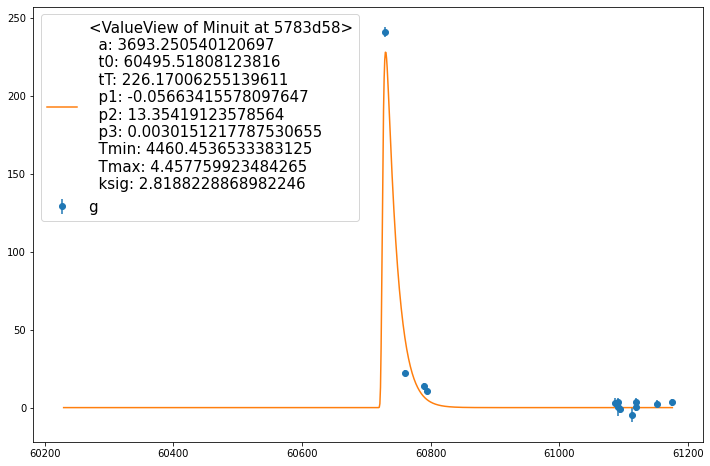

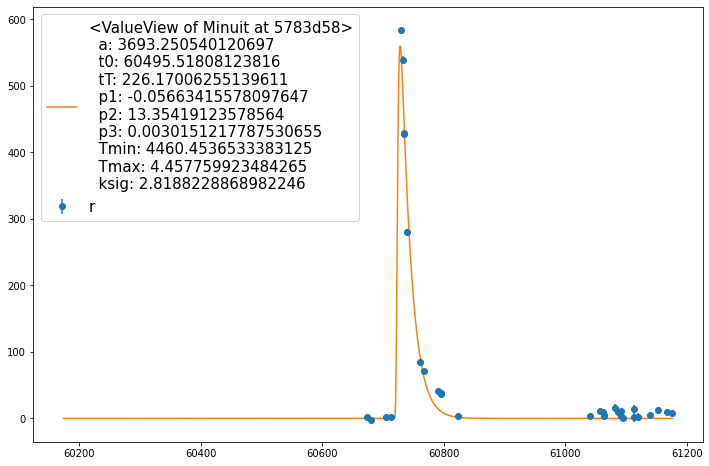

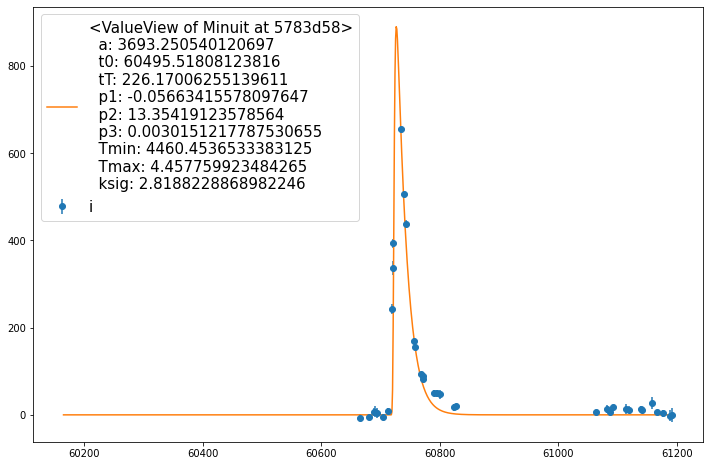

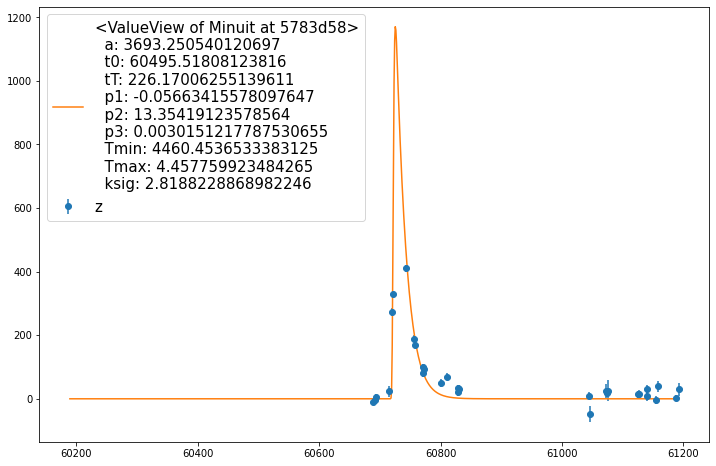

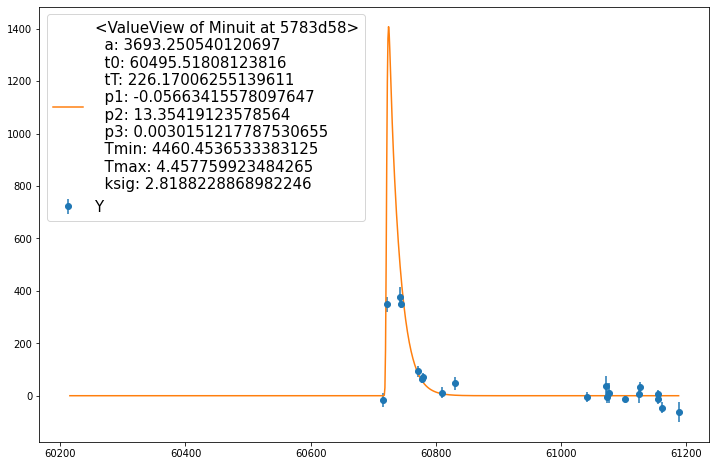

In [15]:
for band in ['u ','g ','r ','i ','z ','Y ']:

    plt.figure(figsize = (12, 8))
    obj = lcs[winner]

    single_band = obj[obj['BAND'] == band]
    flux = single_band['FLUXCAL']
    fluxerr = single_band['FLUXCALERR']
    mjd = single_band['MJD']

    xtime = np.linspace(mjd.min()-500, mjd.max(), 1000)
    x = np.array([xtime,[freq_dic.get(band)]*len(xtime)]).T

    plt.errorbar(mjd, flux, yerr=fluxerr, fmt='o', label = band)

    plt.plot(xtime, Fnu_bump(x, **fit_bump.values), label=fit_bump.values)

    plt.legend(fontsize = 15)